In [5]:
pip install tensorflow --upgrade


In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [5]:
import cv2
import os
import numpy as np
from tensorflow.keras.applications import VGG16  # Ensure TensorFlow is properly installed
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Paths to the dataset folders
normal_path = r'C:\Users\shamb\OneDrive\Desktop\Clg MITVPU\Project\Dataset\TB_Chest_Radiography_Database\Normal'
tb_path = r'C:\Users\shamb\OneDrive\Desktop\Clg MITVPU\Project\Dataset\TB_Chest_Radiography_Database\Tuberculosis'

# Function to process images from a folder and assign labels
def process_images(folder_path, label):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):  # Check for image files
            file_path = os.path.join(folder_path, filename)
            image = cv2.imread(file_path)
            if image is not None:
                # Convert image to grayscale
                gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                # Resize image to a consistent shape (e.g., 224x224)
                gray_image = cv2.resize(gray_image, (224, 224))
                # Normalize pixel values to range [0, 1]
                gray_image = gray_image / 255.0
                images.append(gray_image)
                labels.append(label)
    return images, labels

# Process Normal and TB_Affected images
normal_images, normal_labels = process_images(normal_path, label=0)  # 0 for normal
tb_images, tb_labels = process_images(tb_path, label=1)  # 1 for TB affected

# Combine images and labels
all_images = normal_images + tb_images
all_labels = normal_labels + tb_labels
print(f"Total images: {len(all_images)}, Total labels: {len(all_labels)}")

# Convert lists to numpy arrays
all_images = np.array(all_images).reshape(-1, 224, 224, 1)  # Add channel dimension (grayscale)
all_labels = np.array(all_labels)

# Convert grayscale to RGB by duplicating channels
all_images = np.repeat(all_images, 3, axis=-1)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)

# Convert labels to categorical (one-hot encoding)
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

print(f"Training data: {len(X_train)} images")
print(f"Testing data: {len(X_test)} images")

# Load VGG-16 model without the top classification layer
from tensorflow.keras.applications import VGG16
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in vgg_base.layers:
    layer.trainable = False

# Add custom classification layers
model = Sequential([
    vgg_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # 2 classes: Normal and TB Affected
])

# Compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Fit the model
batch_size = 32
train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)

history = model.fit(
    train_generator,
    epochs=10,  # You can increase this for better training
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) // batch_size,
    validation_steps=len(X_test) // batch_size
)

# Save the trained model in the newer format (.keras)
model.save("tb_detection_vgg16.keras")

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


Total images: 1400, Total labels: 1400
Training data: 1120 images
Testing data: 280 images
Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 123s 3s/step - accuracy: 0.5953 - loss: 1.9515 - val_accuracy: 0.8964 - val_loss: 0.2680
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 125s 4s/step - accuracy: 0.8780 - loss: 0.3098 - val_accuracy: 0.9429 - val_loss: 0.1916
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 117s 3s/step - accuracy: 0.9060 - loss: 0.2493 - val_accuracy: 0.9500 - val_loss: 0.1412
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 117s 3s/step - accuracy: 0.9194 - loss: 0.2036 - val_accuracy: 0.9464 - val_loss: 0.1471
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 116s 3s/step - accuracy: 0.9379 - loss: 0.1860 - val_accuracy: 0.9571 - val_loss: 0.1218
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 122s 4s/step - accuracy: 0.9145 - loss: 0.2130 - val_accuracy: 0.9607 - val_loss: 0.1189
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 116s 3s/step - accuracy: 0.9442 - loss: 0.1448 - val_accuracy: 0.9464 - val_loss: 0.1286
Epoch 8/10
35/35 ━━━

Total images: 1400, Total labels: 1400
Training data: 1120 images
Testing data: 280 images
Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 112s 3s/step - accuracy: 0.6171 - loss: 2.5706 - val_accuracy: 0.9429 - val_loss: 0.1645
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 101s 3s/step - accuracy: 0.9513 - loss: 0.1621 - val_accuracy: 0.9643 - val_loss: 0.1148
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - accuracy: 0.9644 - loss: 0.1094 - val_accuracy: 0.9679 - val_loss: 0.0956
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step - accuracy: 0.9873 - loss: 0.0693 - val_accuracy: 0.9750 - val_loss: 0.0795
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 113s 3s/step - accuracy: 0.9879 - loss: 0.0593 - val_accuracy: 0.9607 - val_loss: 0.0850
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 112s 3s/step - accuracy: 0.9845 - loss: 0.0543 - val_accuracy: 0.9821 - val_loss: 0.0655
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 107s 3s/step - accuracy: 0.9941 - loss: 0.0213 - val_accuracy: 0.9750 - val_loss: 0.0699
Epoch 8/10
35/35 ━━━━

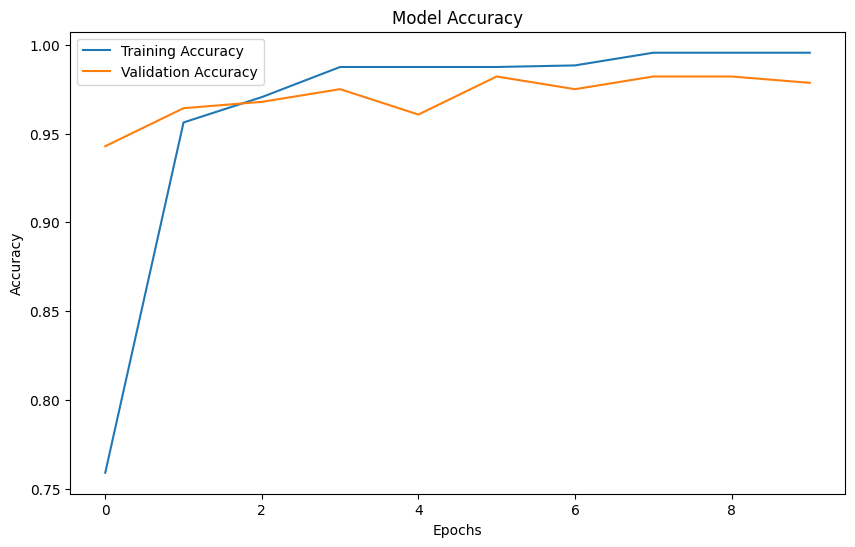

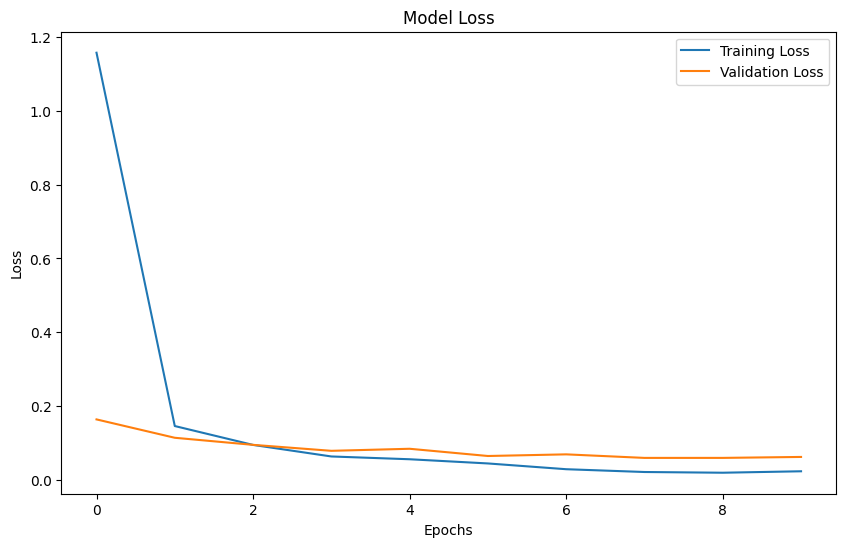

9/9 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step
Confusion Matrix:
 [[138   2]
 [  4 136]]


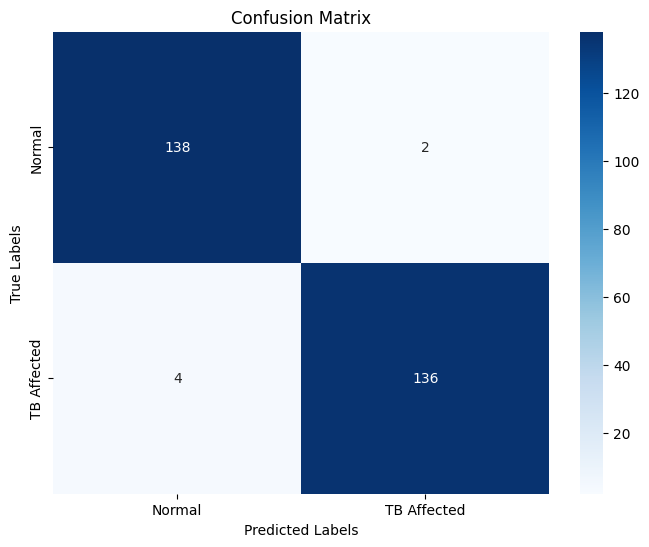

Classification Report:
               precision    recall  f1-score   support

      Normal       0.97      0.99      0.98       140
 TB Affected       0.99      0.97      0.98       140

    accuracy                           0.98       280
   macro avg       0.98      0.98      0.98       280
weighted avg       0.98      0.98      0.98       280



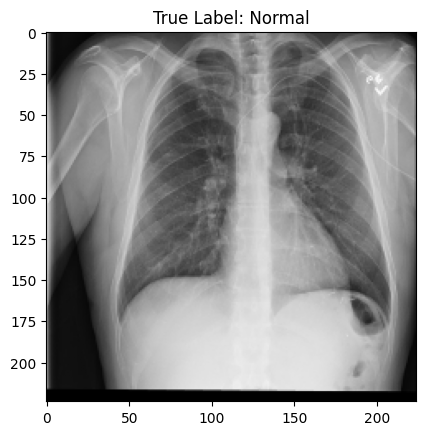

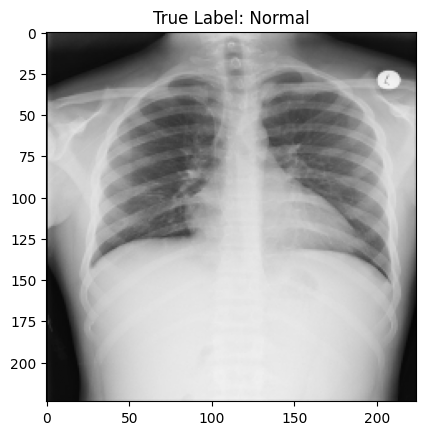

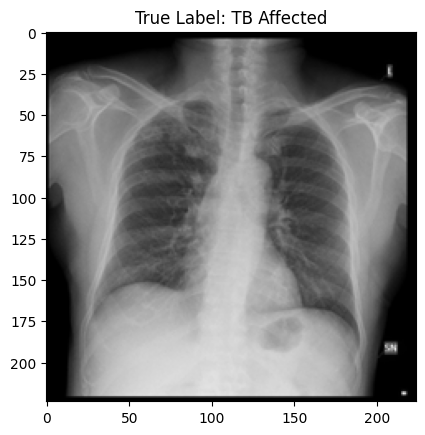

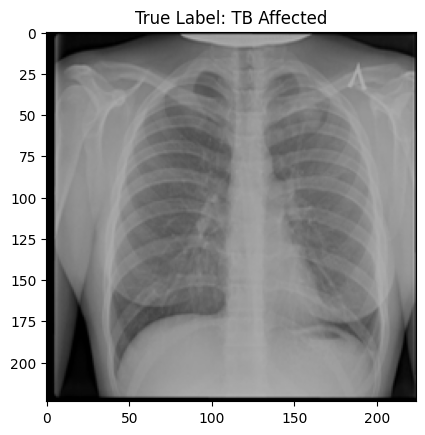

In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Paths to the dataset folders
normal_path = r'C:\Users\shamb\OneDrive\Desktop\Clg MITVPU\Project\Dataset\TB_Chest_Radiography_Database\Normal'
tb_path = r'C:\Users\shamb\OneDrive\Desktop\Clg MITVPU\Project\Dataset\TB_Chest_Radiography_Database\Tuberculosis'

# Function to process images from a folder and assign labels
def process_images(folder_path, label):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):  # Check for image files
            file_path = os.path.join(folder_path, filename)
            image = cv2.imread(file_path)
            if image is not None:
                # Convert image to grayscale
                gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                # Resize image to a consistent shape (e.g., 224x224)
                gray_image = cv2.resize(gray_image, (224, 224))
                # Normalize pixel values to range [0, 1]
                gray_image = gray_image / 255.0
                images.append(gray_image)
                labels.append(label)
    return images, labels

# Process Normal and TB_Affected images
normal_images, normal_labels = process_images(normal_path, label=0)  # 0 for normal
tb_images, tb_labels = process_images(tb_path, label=1)  # 1 for TB affected

# Combine images and labels
all_images = normal_images + tb_images
all_labels = normal_labels + tb_labels
print(f"Total images: {len(all_images)}, Total labels: {len(all_labels)}")

# Convert lists to numpy arrays
all_images = np.array(all_images).reshape(-1, 224, 224, 1)  # Add channel dimension (grayscale)
all_labels = np.array(all_labels)

# Convert grayscale to RGB by duplicating channels
all_images = np.repeat(all_images, 3, axis=-1)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)

# Convert labels to categorical (one-hot encoding)
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

print(f"Training data: {len(X_train)} images")
print(f"Testing data: {len(X_test)} images")

# Create TensorFlow datasets
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Load VGG-16 model without the top classification layer
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in vgg_base.layers:
    layer.trainable = False

# Add custom classification layers
model = Sequential([
    vgg_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # 2 classes: Normal and TB Affected
])

# Compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Train the model using the TensorFlow Dataset API
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset
)

# Save the trained model
model.save("tb_detection_vgg16.keras")

# Evaluate the model
test_loss, test_acc = model.evaluate(test_dataset, verbose=0)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Plot training & validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Generate confusion matrix and classification report
y_pred = model.predict(X_test, batch_size=batch_size)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:\n", cm)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'TB Affected'], yticklabels=['Normal', 'TB Affected'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
report = classification_report(y_true, y_pred_classes, target_names=['Normal', 'TB Affected'])
print("Classification Report:\n", report)

# Display 2 Normal and 2 TB Affected images
normal_count = 0
tb_count = 0

for i in range(len(X_test)):
    if y_true[i] == 0 and normal_count < 2:  # Normal image
        plt.imshow(X_test[i].reshape(224, 224, 3))
        plt.title("True Label: Normal")
        plt.show()
        normal_count += 1
    elif y_true[i] == 1 and tb_count < 2:  # TB Affected image
        plt.imshow(X_test[i].reshape(224, 224, 3))
        plt.title("True Label: TB Affected")
        plt.show()
        tb_count += 1

    # Stop once we have 2 examples from each class
    if normal_count == 2 and tb_count == 2:
        break


Total images: 1400, Total labels: 1400
Training data: 1120 images
Testing data: 280 images
Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 118s 3s/step - accuracy: 0.6423 - loss: 2.5735 - val_accuracy: 0.9357 - val_loss: 0.1546
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 116s 3s/step - accuracy: 0.9367 - loss: 0.1803 - val_accuracy: 0.9607 - val_loss: 0.1492
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 115s 3s/step - accuracy: 0.9803 - loss: 0.0709 - val_accuracy: 0.9679 - val_loss: 0.0857
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 122s 3s/step - accuracy: 0.9844 - loss: 0.0586 - val_accuracy: 0.9750 - val_loss: 0.0765
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 115s 3s/step - accuracy: 0.9834 - loss: 0.0553 - val_accuracy: 0.9821 - val_loss: 0.0624
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 120s 3s/step - accuracy: 0.9958 - loss: 0.0269 - val_accuracy: 0.9786 - val_loss: 0.0613
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 116s 3s/step - accuracy: 0.9955 - loss: 0.0221 - val_accuracy: 0.9679 - val_loss: 0.0802
Epoch 8/10
35/35 ━━━

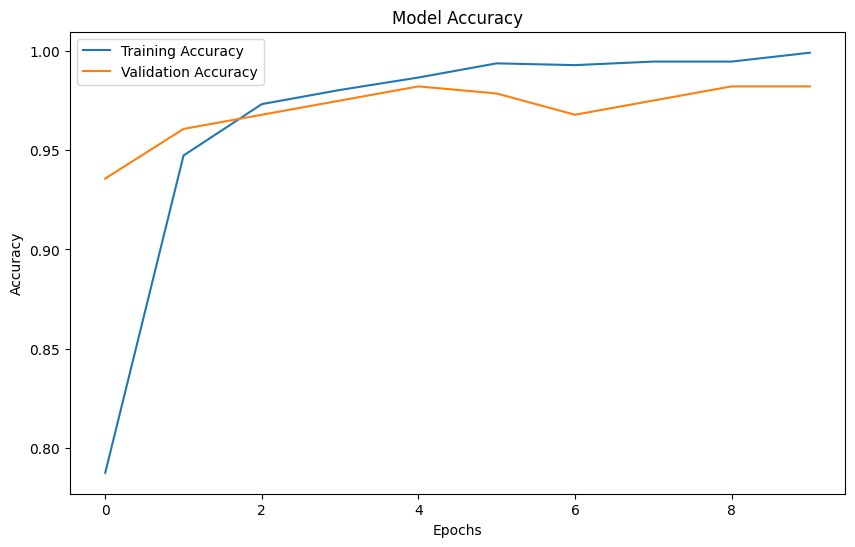

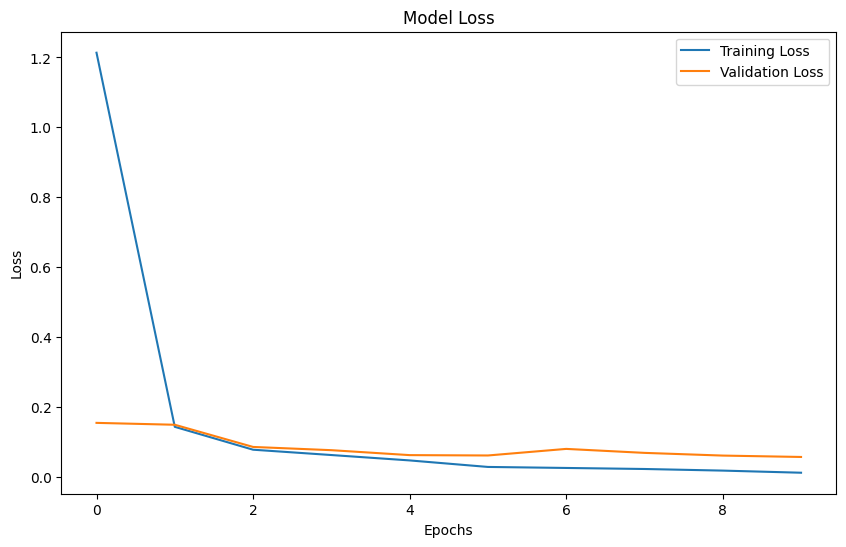

9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step
Confusion Matrix:
 [[138   2]
 [  3 137]]


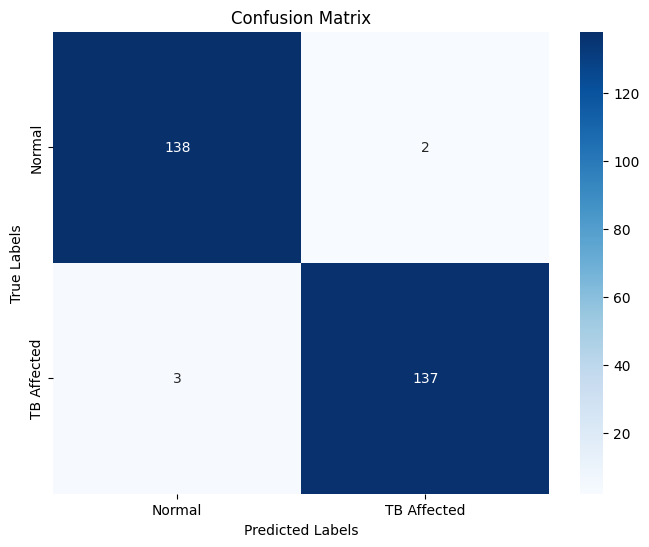

Classification Report:
               precision    recall  f1-score   support

      Normal       0.98      0.99      0.98       140
 TB Affected       0.99      0.98      0.98       140

    accuracy                           0.98       280
   macro avg       0.98      0.98      0.98       280
weighted avg       0.98      0.98      0.98       280



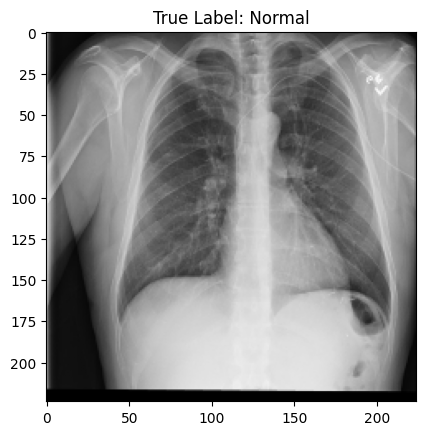

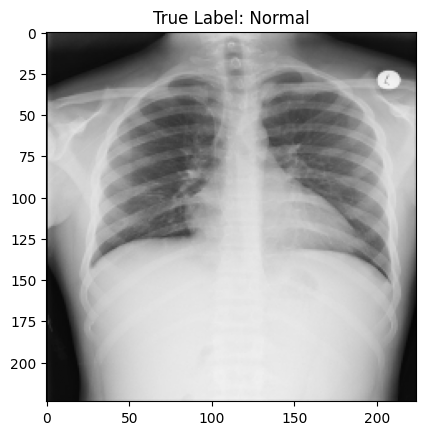

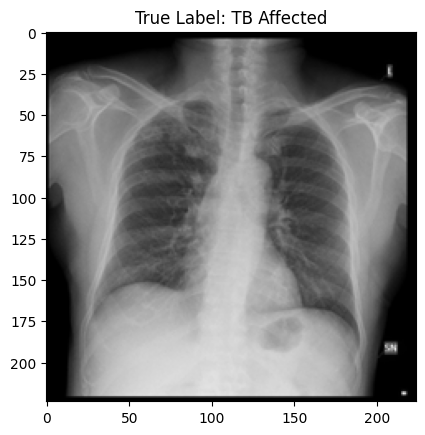

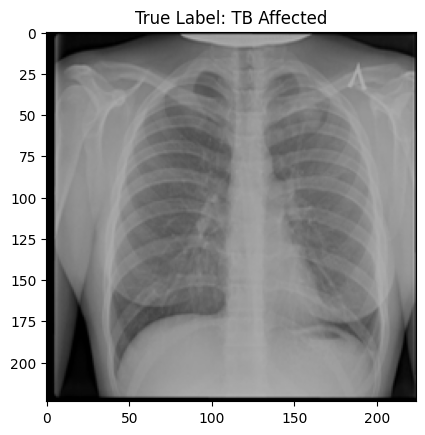

In [3]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Paths to the dataset folders
normal_path = r'C:\Users\shamb\OneDrive\Desktop\Clg MITVPU\Project\Dataset\TB_Chest_Radiography_Database\Normal'
tb_path = r'C:\Users\shamb\OneDrive\Desktop\Clg MITVPU\Project\Dataset\TB_Chest_Radiography_Database\Tuberculosis'

# Function to process images from a folder and assign labels
def process_images(folder_path, label):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):  # Check for image files
            file_path = os.path.join(folder_path, filename)
            image = cv2.imread(file_path)
            if image is not None:
                # Convert image to grayscale
                gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                # Resize image to a consistent shape (e.g., 224x224)
                gray_image = cv2.resize(gray_image, (224, 224))
                # Normalize pixel values to range [0, 1]
                gray_image = gray_image / 255.0
                images.append(gray_image)
                labels.append(label)
    return images, labels

# Process Normal and TB_Affected images
normal_images, normal_labels = process_images(normal_path, label=0)  # 0 for normal
tb_images, tb_labels = process_images(tb_path, label=1)  # 1 for TB affected

# Combine images and labels
all_images = normal_images + tb_images
all_labels = normal_labels + tb_labels
print(f"Total images: {len(all_images)}, Total labels: {len(all_labels)}")

# Convert lists to numpy arrays
all_images = np.array(all_images).reshape(-1, 224, 224, 1)  # Add channel dimension (grayscale)
all_labels = np.array(all_labels)

# Convert grayscale to RGB by duplicating channels
all_images = np.repeat(all_images, 3, axis=-1)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)

# Convert labels to categorical (one-hot encoding)
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

print(f"Training data: {len(X_train)} images")
print(f"Testing data: {len(X_test)} images")

# Create TensorFlow datasets
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Load VGG-16 model without the top classification layer
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in vgg_base.layers:
    layer.trainable = False

# Add custom classification layers
model = Sequential([
    vgg_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # 2 classes: Normal and TB Affected
])

# Compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Train the model using the TensorFlow Dataset API
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset
)

# Save the trained model
model.save("tb_detection_vgg16.keras")

# Evaluate the model
test_loss, test_acc = model.evaluate(test_dataset, verbose=0)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Plot training & validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Generate confusion matrix and classification report
y_pred = model.predict(X_test, batch_size=batch_size)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:\n", cm)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'TB Affected'], yticklabels=['Normal', 'TB Affected'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
report = classification_report(y_true, y_pred_classes, target_names=['Normal', 'TB Affected'])
print("Classification Report:\n", report)

# Display 2 Normal and 2 TB Affected images
normal_count = 0
tb_count = 0

for i in range(len(X_test)):
    if y_true[i] == 0 and normal_count < 2:  # Normal image
        plt.imshow(X_test[i].reshape(224, 224, 3))
        plt.title("True Label: Normal")
        plt.show()
        normal_count += 1
    elif y_true[i] == 1 and tb_count < 2:  # TB Affected image
        plt.imshow(X_test[i].reshape(224, 224, 3))
        plt.title("True Label: TB Affected")
        plt.show()
        tb_count += 1

    # Stop once we have 2 examples from each class
    if normal_count == 2 and tb_count == 2:
        break
